In [1]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.spellchecker.data.datasets.csv_dataset import CSVDataset

In [4]:
dataset = CSVDataset(
    csv_folder="../data/training",
    input_column="source_text",
    target_column="target_text",
)

[INFO] Loaded 49496 examples from 4 CSV files.
[INFO] Train examples: 43061, Validation examples: 6435


In [6]:
train_df = dataset.train_df
val_df = dataset.val_df

In [8]:
train_df['len'] = train_df['source_text'].apply(len)

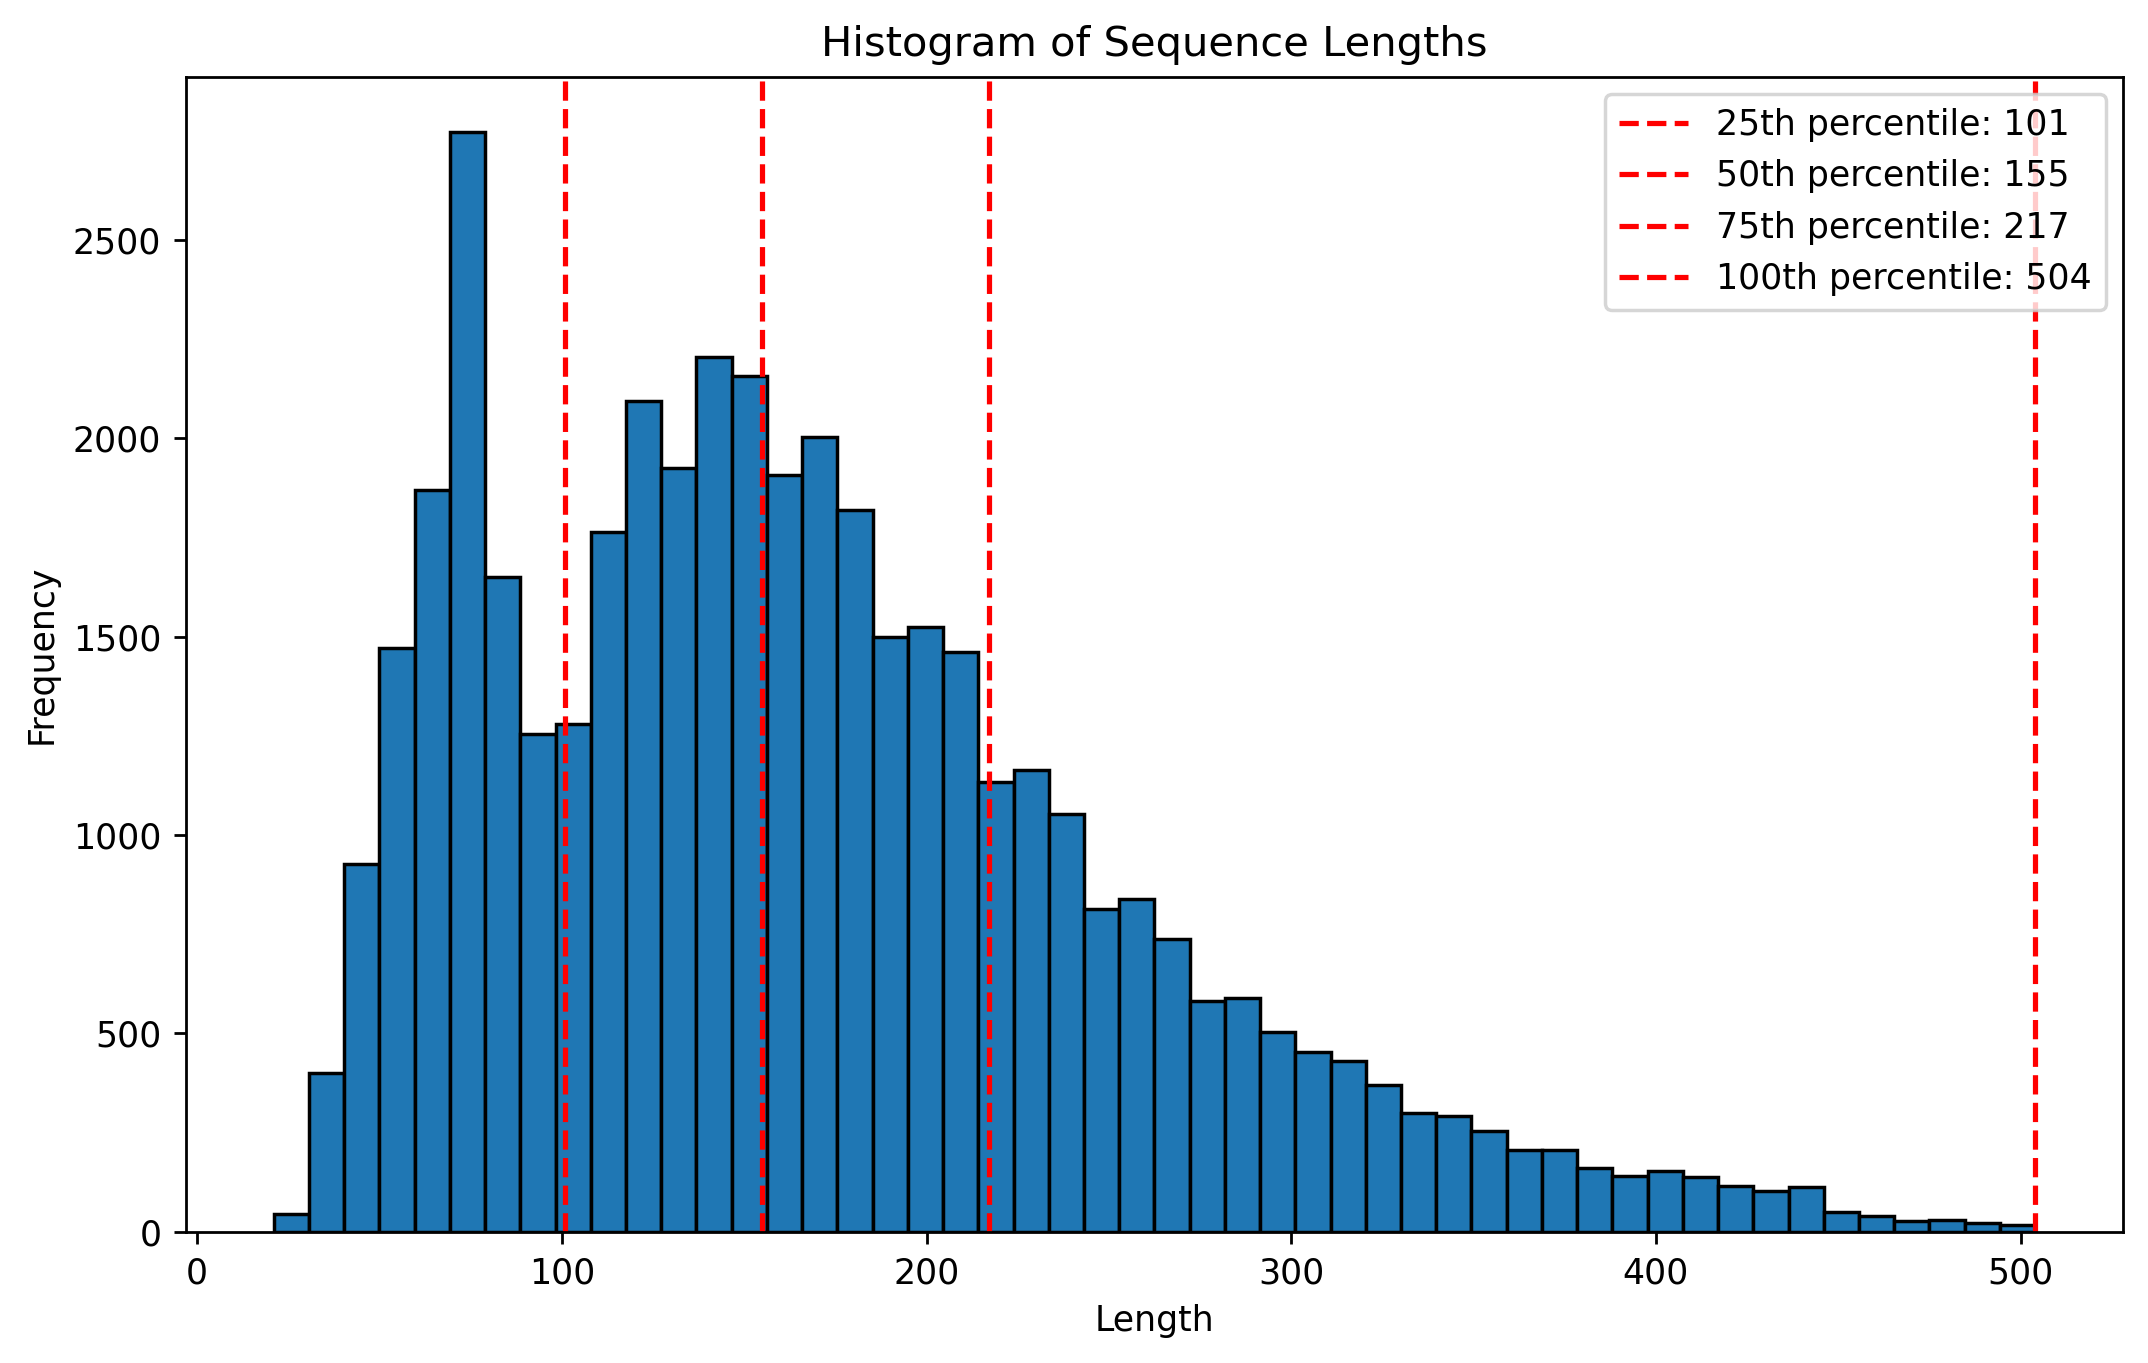

In [13]:
import matplotlib.pyplot as plt
import numpy as np

data = train_df["len"]

percentile_values = [25, 50, 75, 100]
percentiles = np.percentile(data, percentile_values)

plt.figure(figsize=(10, 6), dpi=250)
plt.hist(data, bins=50, edgecolor="black")
plt.title("Histogram of Sequence Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")

for perc_val, p in zip(percentile_values, percentiles):
    plt.axvline(
        p, color="red", linestyle="--", label=f"{perc_val}th percentile: {int(p)}"
    )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

#### The length distribution seems fine, we balance between short and long examples

In [17]:
identical_df = train_df[train_df['source_text'] == train_df['target_text']]

count_identical = len(identical_df)
total_count = len(train_df)
proportion = count_identical / total_count * 100

print(f"Number of identical source/target rows: {count_identical}")
print(f"Proportion of dataset: {proportion:.2f}%")

Number of identical source/target rows: 65
Proportion of dataset: 0.15%


In [23]:
identical_df['source_text'].sample(5).tolist()

['• A warm welcome. Thank you for choosing us! • Welcome! We look forward to serving you. • A warm welcome from all of us.',
 'Fatty liver has been documented in up to 10 to 15 percent of normal individuals and 70 to 80 percent of obese individuals.',
 'This can be easily seen in restaurants or cafes nowadays.',
 'Many tattoo crosses can have a clutter and other images mixed up with them but I tend to admire the cleanliness of this one.',
 "I know! It's short, but is just the beginning. Anyways. Remember I said I didn't know if it was going to be a story or a novel?"]

#### Additional filtration for synthetic data is needed. We will use LLM-as-a-judge technique to filter out the bad examples

Levenshtein distance statistics:
count    43061.000000
mean         3.182555
std          3.633583
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max        329.000000
Name: lev_distance, dtype: float64

Number of outliers (>11.0 distance): 350


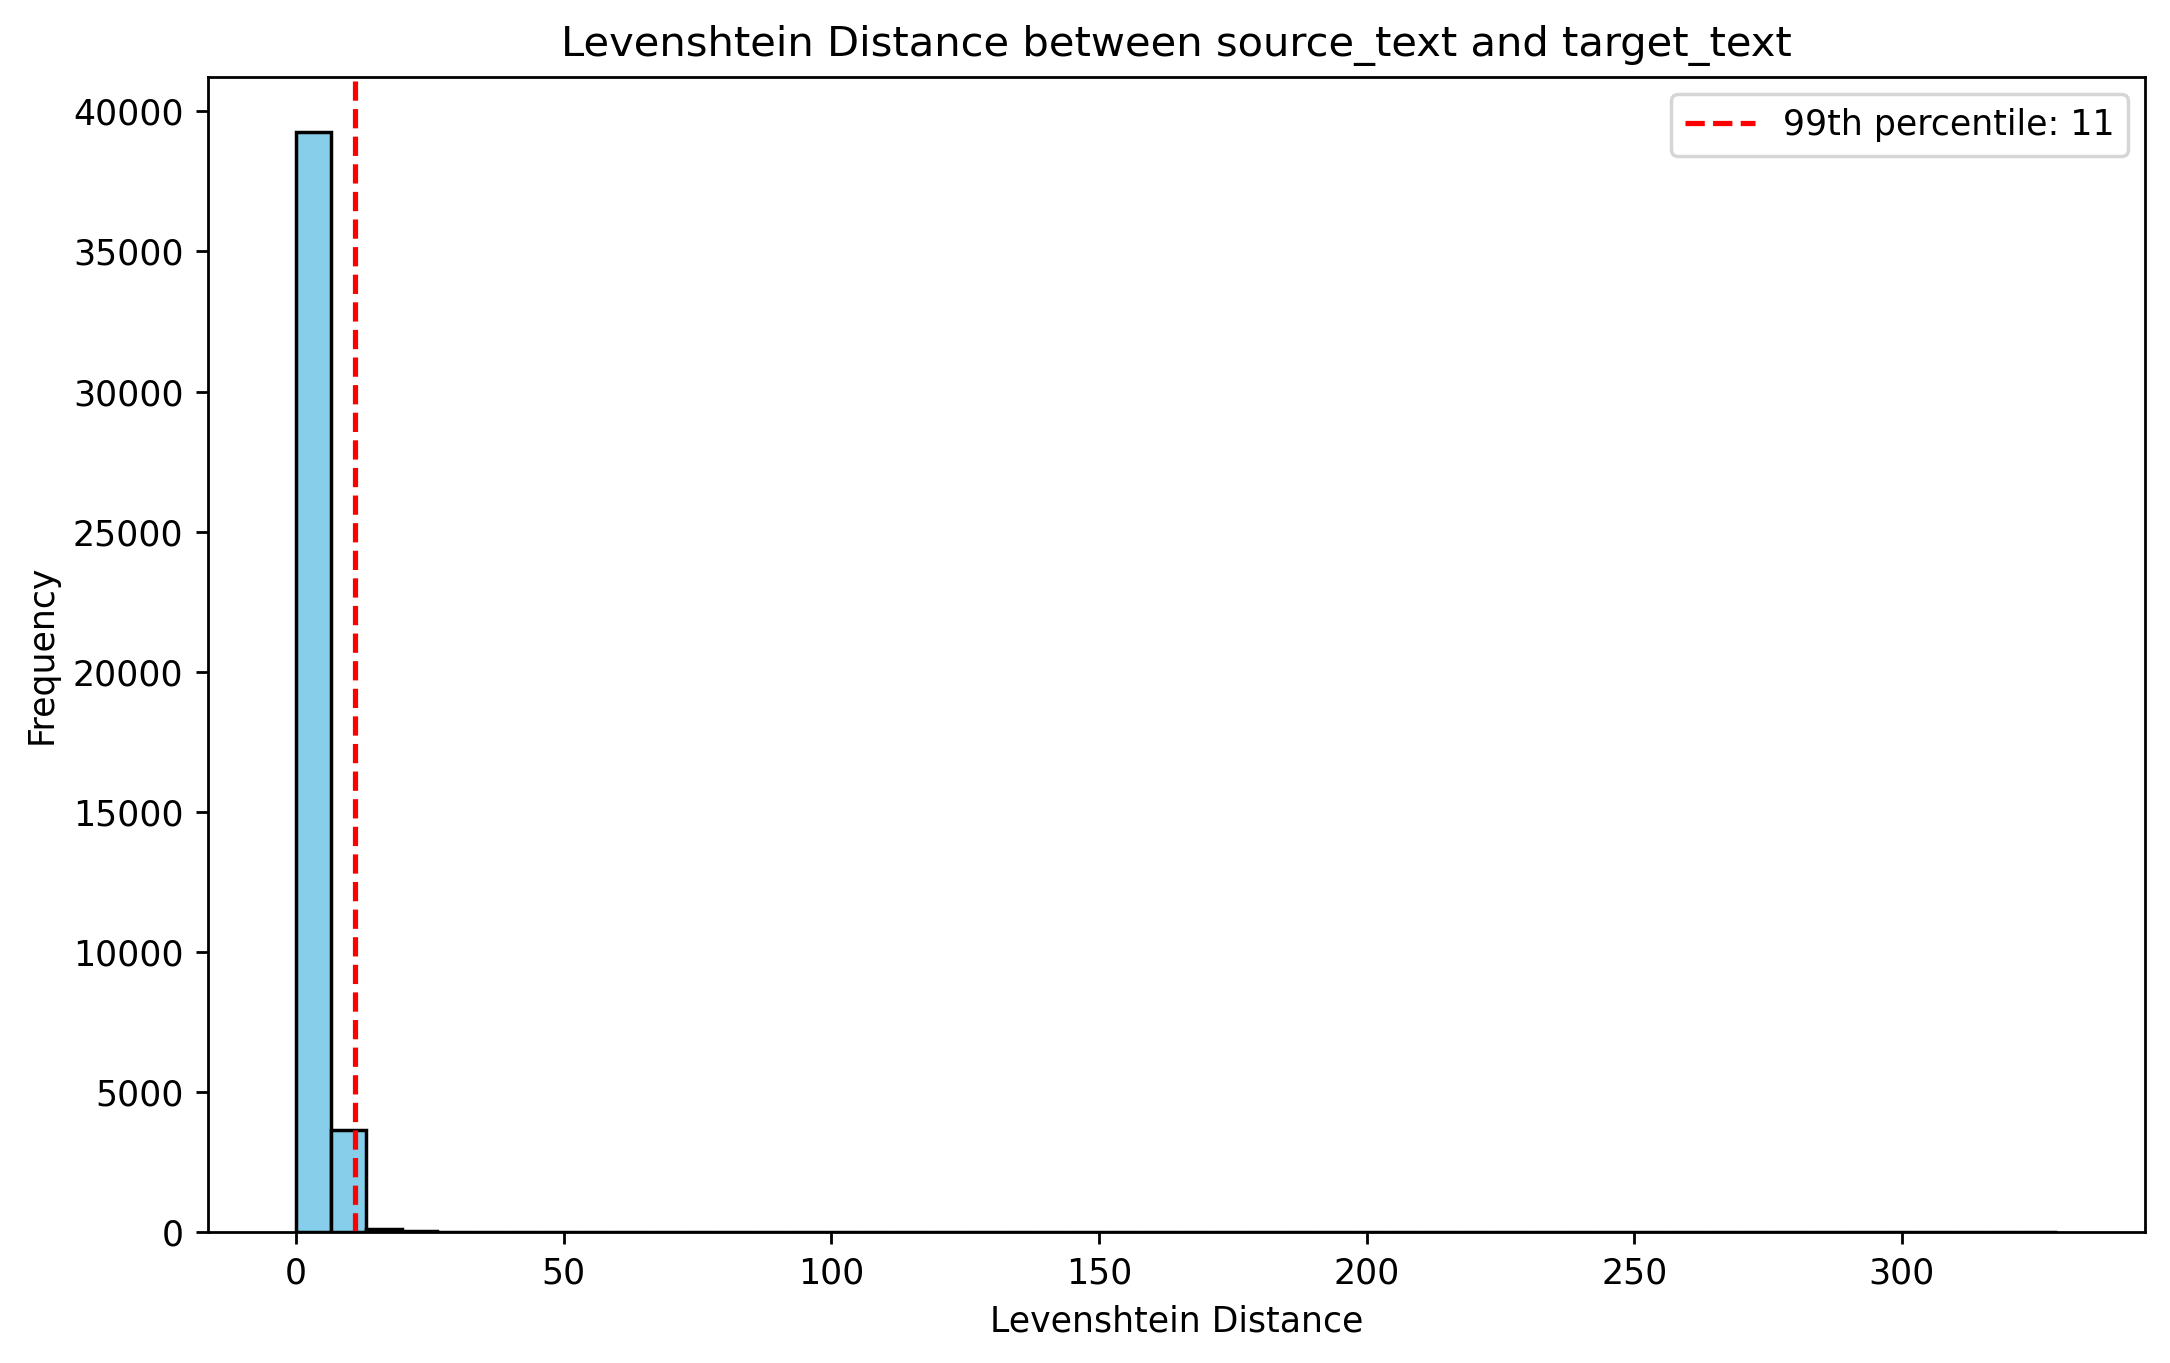

In [31]:
import Levenshtein
import matplotlib.pyplot as plt

# Compute Levenshtein distance
train_df['lev_distance'] = train_df.apply(
    lambda row: Levenshtein.distance(str(row['source_text']), str(row['target_text'])), axis=1
)

# Basic statistics
lev_stats = train_df['lev_distance'].describe()
print("Levenshtein distance statistics:")
print(lev_stats)

# Identify outliers: for example, distances above 99th percentile
threshold = train_df['lev_distance'].quantile(0.99)
outliers = train_df[train_df['lev_distance'] > threshold]
print(f"\nNumber of outliers (>{threshold} distance): {len(outliers)}")

plt.figure(figsize=(10, 6), dpi=250)
plt.hist(train_df['lev_distance'], bins=50, color="skyblue", edgecolor="black")
plt.axvline(threshold, color="red", linestyle="--", label=f"99th percentile: {int(threshold)}")
plt.title("Levenshtein Distance between source_text and target_text")
plt.xlabel("Levenshtein Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [40]:
example = outliers.iloc[0]

print(f"=== SOURCE TEXT: ===\n{example['source_text']}")
print(f"=== TARGET TEXT: ===\n{example['target_text']}")

=== SOURCE TEXT: ===
The two-part episode “tHe Bionic Woman” is the first in the set to get a commentary, adn it’s a Typically well-prepared, One from the episodes’ writer (and later producer of both “The Six Million Dollar Man and its spin-off “Ahe Bionic Woman”) Kenneth Johnson, as he goes into lots of detail about the development of the original idea and the storyline, and also how Universal wanted a romantic episode with a death at teh end to cash in on the success at the tme of The movie “Love Story”.
=== TARGET TEXT: ===
The two-part episode “The Bionic Woman” is the first in the set to get a commentary, and it’s a typically well-prepared one from the episodes’ writer (and later producer of both “The Six Million Dollar Man and its spin-off “The Bionic Woman”) Kenneth Johnson, as he goes into lots of detail about the development of the original idea and the storyline, and also how Universal wanted a romantic episode with a death at the end to cash in on the success at the time of 

In [41]:
example = outliers.iloc[1]

print(f"=== SOURCE TEXT: ===\n{example['source_text']}")
print(f"=== TARGET TEXT: ===\n{example['target_text']}")

=== SOURCE TEXT: ===
Later the Seal was Dan, nautre supra sohes the king of fairy dsupra shoesappear, as a kind of celestial many day king had also want to attack The Van, take out which those sleeping nature god Dan, even find qthe body of the Lrd of Da,n but are not albe to success, because the Lodr of life in the Dan decorate down the seal of very severe, unless he himself supra shoes to fiVnd the key of god of the loss of Dan.
=== TARGET TEXT: ===
Later the seal was Dan, nature supra shoes the king of fairy dsupra shoesappear, as a kind of celestial many day king had also want to attack the Dan, take out which those sleeping nature god Dan, even find the body of the Lord of Dan, but are not able to success, because the Lord of life in the Dan decorate down the seal of very severe, unless he himself supra shoes to find the key of god of the loss of Dan.


![](../docs/images/diff_example.png)

#### Seems OK, let's leave such outliers as they are